In [2]:
# Lets install ktrain - A Lightweight Wrapper for Keras to Help Train Neural Networks

pip install ktrain

In [8]:
# lets load the training dataset and give column names

import pandas as pd

train = pd.read_csv('/content/sample_data/atis_intents_train.csv', header=None)
train.columns = ['intent', 'query']
train.head()

,intent,query
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...


In [9]:
# lets load the test dataset and give the column names

import pandas as pd

test = pd.read_csv('/content/sample_data/atis_intents_test.csv', header=None)
test.columns = ['intent', 'query']
test.head()

,intent,query
0,atis_flight,i would like to find a flight from charlotte ...
1,atis_airfare,on april first i need a ticket from tacoma to...
2,atis_flight,on april first i need a flight going from pho...
3,atis_flight,i would like a flight traveling one way from ...
4,atis_flight,i would like a flight from orlando to salt la...


In [10]:
train.shape, test.shape

((4834, 2), (800, 2))

In [21]:
# lets check the unique intent categories

intent_categories_train = train['intent'].value_counts()
intent_categories_train

atis_flight            3666
atis_airfare            423
atis_ground_service     255
atis_airline            157
atis_abbreviation       147
atis_aircraft            81
atis_flight_time         54
atis_quantity            51
Name: intent, dtype: int64

In [22]:
test['intent'].value_counts()

atis_flight            632
atis_airfare            48
atis_airline            38
atis_ground_service     36
atis_abbreviation       33
atis_aircraft            9
atis_quantity            3
atis_flight_time         1
Name: intent, dtype: int64

In [24]:
# verified that intents are common across train and test. They are 8 in total 

intent_categories = intent_categories_train.index.tolist()
intent_categories

['atis_flight',
 'atis_airfare',
 'atis_ground_service',
 'atis_airline',
 'atis_abbreviation',
 'atis_aircraft',
 'atis_flight_time',
 'atis_quantity']

In [39]:
# lets build X_train, y_train and X_test, y_test

import numpy as np

X_train = np.array(train['query'])
y_train = np.array(train['intent'])

X_test, y_test = np.array(test['query']), np.array(test['intent'])

In [41]:
X_train

array([' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning',
       ' what flights are available from pittsburgh to baltimore on thursday morning',
       ' what is the arrival time in san francisco for the 755 am flight leaving washington',
       ..., ' which airlines fly into and out of denver',
       ' does continental fly from boston to san francisco with a stop in denver',
       ' is there a delta flight from denver to san francisco'],
      dtype=object)

# Lets build DistilBERT based NLP model to predict the intent based on query

In [29]:
import ktrain 
from ktrain import text

In [30]:
model_name = 'distilbert-base-uncased'

trans = text.Transformer(model_name, maxlen=512, class_names=intent_categories)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [42]:
train_data = trans.preprocess_train(X_train, y_train)
test_data = trans.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 11
	95percentile : 19
	99percentile : 25


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 10
	95percentile : 17
	99percentile : 21


In [43]:
train_data

In [45]:
model = trans.get_classifier()

learner = ktrain.get_learner(model, train_data=train_data, val_data=test_data, batch_size=16)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
302/302 [==============================] - 533s 2s/step - loss: 1.3573 - accuracy: 0.7601
Epoch 2/3
302/302 [==============================] - 522s 2s/step - loss: 0.7733 - accuracy: 0.8281
Epoch 3/3
302/302 [==============================] - 84s 275ms/step - loss: 2.5969 - accuracy: 0.6208


done.
Visually inspect loss plot and select learning rate associated with falling loss


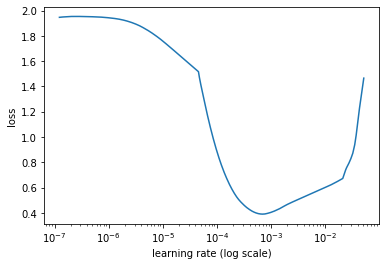

In [48]:
# lets figure out the approx. optimal learning rate 

learner.lr_find(show_plot=True, max_epochs=3)

In [50]:
# the best learning rate is where the loss starts to reduce. It appears to be 1e-4 from above graph

learner.fit_onecycle(1e-4, 4)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/4
303/303 [==============================] - 525s 2s/step - loss: 0.4165 - accuracy: 0.8916 - val_loss: 0.0520 - val_accuracy: 0.9875
Epoch 2/4
303/303 [==============================] - 523s 2s/step - loss: 0.0720 - accuracy: 0.9837 - val_loss: 0.0437 - val_accuracy: 0.9925
Epoch 3/4
303/303 [==============================] - 523s 2s/step - loss: 0.0511 - accuracy: 0.9876 - val_loss: 0.0513 - val_accuracy: 0.9912
Epoch 4/4
303/303 [==============================] - 523s 2s/step - loss: 0.0211 - accuracy: 0.9954 - val_loss: 0.0551 - val_accuracy: 0.9887


In [51]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [52]:
my_query = "what is the cost of travel from Miami, FL to San Diego, CA? "
my_query

'what is the cost of travel from Miami, FL to San Diego, CA? '

In [53]:
predictor.predict(my_query)

'atis_airfare'

In [70]:
# Lets try to build a list with various queries and see if they would be predicted correctly!

query_list = ["How many flights run between Atlanta, GA and Miami, FL?",
              "What rental car agencies are available at Washington DC",
              "When will last flight leaving time from Atlanta, GA to Boston, MA",
              "what is the best airline at Atlanta, GA",
              "what round trip flight is available between Atlanta, GA and Clevand, OH for the same day",
              "Which airline provides cheapest ticket between Atlanta, GA and Washington DC",
              "What additional features does a boeing provide compared to other aircraft",
              "what does the code BUS standfor"
              
]

for q in query_list:
  print('Query: ', q)
  print('Preicted Category: ', predictor.predict(q))
  print('--'* 75)

Query:  How many flights run between Atlanta, GA and Miami, FL?
Preicted Category:  atis_quantity
------------------------------------------------------------------------------------------------------------------------------------------------------
Query:  What rental car agencies are available at Washington DC
Preicted Category:  atis_ground_service
------------------------------------------------------------------------------------------------------------------------------------------------------
Query:  When will last flight leaving time from Atlanta, GA to Boston, MA
Preicted Category:  atis_flight_time
------------------------------------------------------------------------------------------------------------------------------------------------------
Query:  what is the best airline at Atlanta, GA
Preicted Category:  atis_airline
------------------------------------------------------------------------------------------------------------------------------------------------------
Qu

In [71]:
predictor.save('distilbert_atis_intent_classifier')

In [72]:
!zip -r /content/distilbert_atis_intent_classifier.zip /content/distilbert_atis_intent_classifier

  adding: content/distilbert_atis_intent_classifier/ (stored 0%)
  adding: content/distilbert_atis_intent_classifier/vocab.txt (deflated 53%)
  adding: content/distilbert_atis_intent_classifier/tf_model.h5 (deflated 8%)
  adding: content/distilbert_atis_intent_classifier/special_tokens_map.json (deflated 40%)
  adding: content/distilbert_atis_intent_classifier/tokenizer_config.json (deflated 40%)
  adding: content/distilbert_atis_intent_classifier/config.json (deflated 53%)
  adding: content/distilbert_atis_intent_classifier/tf_model.preproc (deflated 46%)
  adding: content/distilbert_atis_intent_classifier/tokenizer.json (deflated 59%)


In [73]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
cchardet==2.1.7
certifi==2021.5.30
cffi==1.14.6
cftime==1.5.1
chardet==3.0.4
charset-normalizer==2.0.6
clang==5.0
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.24
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
desca

In [74]:
!pip freeze > requirements.txt